# Deep SVDD on real images

In [ ]:
!pip install git+https://github.com/jeanollion/dataset_iterator.git
!pip install git+https://github.com/jeanollion/distnet.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

# DRIVE
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/BACMMAN_DISTNET/')

from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

# copy data locallly
dataset_dir = f"/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/"
!cp "/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/train_val_eval.h5" "/home/train_val_eval.h5"
dataset_path = "/home/train_val_eval.h5"
print(dataset_path)

!nvidia-smi

  Cloning https://github.com/jeanollion/dataset_iterator.git to /tmp/pip-req-build-m_qjxuzo
  Running command git clone -q https://github.com/jeanollion/dataset_iterator.git /tmp/pip-req-build-m_qjxuzo
  Created wheel for dataset-iterator: filename=dataset_iterator-0.0.1-cp36-none-any.whl size=35945 sha256=9a3983a5beef240c090ee72d2200ddb2956d867a0950855ca5be53213cb837ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-65lm89s8/wheels/e1/b1/4a/efb8888afaa53e058db8520c203e13af93ca10b2a8d42ab098
Successfully built dataset-iterator
  Cloning https://github.com/jeanollion/distnet.git to /tmp/pip-req-build-fu9xbfh1
  Running command git clone -q https://github.com/jeanollion/distnet.git /tmp/pip-req-build-fu9xbfh1
  Created wheel for distnet: filename=distnet-0.0.1-cp36-none-any.whl size=51344 sha256=750d1d3e8121e8fd4be34084ec124d5dfb752799423edc8bd64c92c260260bce
  Stored in directory: /tmp/pip-ephem-wheel-cache-uiyc9zpn/wheels/12/6e/51/1b4851b9716ec2b0d0db57e350ee2eea8d95cb244578fea6f8
Su

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


/home/train_val_eval.h5
Sun Aug  2 15:09:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                

## Load dataset

In [ ]:
# concatenate evaluation sets (norm only and anormal only) into a single h5
# file --> more convenient to load them into a single iterator after

from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator

eval_set_path = "/home/eval_set.h5"

# evaluation set, nominal and anormal classes ()
x_test_norm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_norm",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )

x_test_anorm = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval_anom",
                                input_channels=[0],
                                output_channels=[0], 
                                batch_size=64
                                )


def get_images(iterator):
    images = []
    for i in range(len(iterator)):
        bx, by = iterator[i]
        for im in bx:
            images.append(im)
    return np.array(images)

# get images
nominal_images = get_images(x_test_norm)
n_nominal = nominal_images.shape[0]
print(f"{n_nominal} nominal images")
anormal_images = get_images(x_test_anorm)
n_anormal = anormal_images.shape[0]
print(f"{n_anormal} anormal images")

with h5py.File(eval_set_path, 'w') as out_file:
    out_file.create_dataset("eval/0/raw", data=get_images(x_test_norm))
    out_file.create_dataset("eval/0/labels", data=np.zeros(n_nominal))
    out_file.create_dataset("eval/1/raw", data=get_images(x_test_anorm))
    out_file.create_dataset("eval/1/labels", data=np.array([1 for i in range(n_anormal)]))

851 nominal images
1011 anormal images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from distnet.utils.pre_processing import random_scaling

corruption_function = lambda im: im + np.random.uniform(0, 1, im.shape) 
image_scaling = PreProcessingImageGenerator(lambda im:im/255.) 

def global_contrast_normalization(im, s=1, lmda=1, epsilon=1e-9):
    mu = np.mean(im)
    im = im - mu
    contrast = np.sqrt(lmda + np.mean(im**2))
    im = s * im / max(contrast, epsilon)
    return im

data_gen_train = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                height_shift_range=0.2,
                                channel_shift_range=0.2,
                                fill_mode="nearest",
                                preprocessing_function=random_scaling)

image_scaling = ImageDataGenerator(preprocessing_function=random_scaling)

def corruption_random_scaling(batch_by_channel):
    batch_by_channel[1] = np.copy(batch_by_channel[0]) # creating channel 1
    batch_by_channel[0] = corruption_function(batch_by_channel[0])  # corruption on channel 0 only
    # batch_by_channel[0], batch_by_channel[1] = random_scaling(batch_by_channel[0]), random_scaling(batch_by_channel[1])
    # batch_by_channel[0], batch_by_channel[1] = global_contrast_normalization(batch_by_channel[0]), global_contrast_normalization(batch_by_channel[1])


def put_nominal_labels(batch_by_channel):
    size = len(batch_by_channel[0])
    batch_by_channel[1] = np.zeros(size)


def put_anormal_labels(batch_by_channel):
    size = len(batch_by_channel[0])
    batch_by_channel[1] = np.ones(size)

# train set, interest class only ([augmentation + corruption, augmentation without corruption])
x_train = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw", None],
                                group_keyword = "train", 
                                input_channels=[0],
                                output_channels=[1], 
                                image_data_generators=[data_gen_train, None],
                                channels_postprocessing_function=corruption_random_scaling,
                                batch_size=4
                                )

# validation set, interest class only ([augmentation without corruption])
x_val = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "val",
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[data_gen_train],
                                batch_size=4
                                )

# evaluation set, nominal and anormal classes ()
x_test = MultiChannelIterator(dataset=eval_set_path, 
                                channel_keywords=["/raw", "/labels"],
                                group_keyword = ["eval/{}/".format(lab) for lab in range(2)],
                                input_channels=[0],
                                output_channels=[0, 1], 
                                image_data_generators=[image_scaling, None],
                                batch_size=64
                                )

print(f"Number of batches {len(x_train)} of size {len(x_train[0][0])}")

Number of batches 2467 of size 4


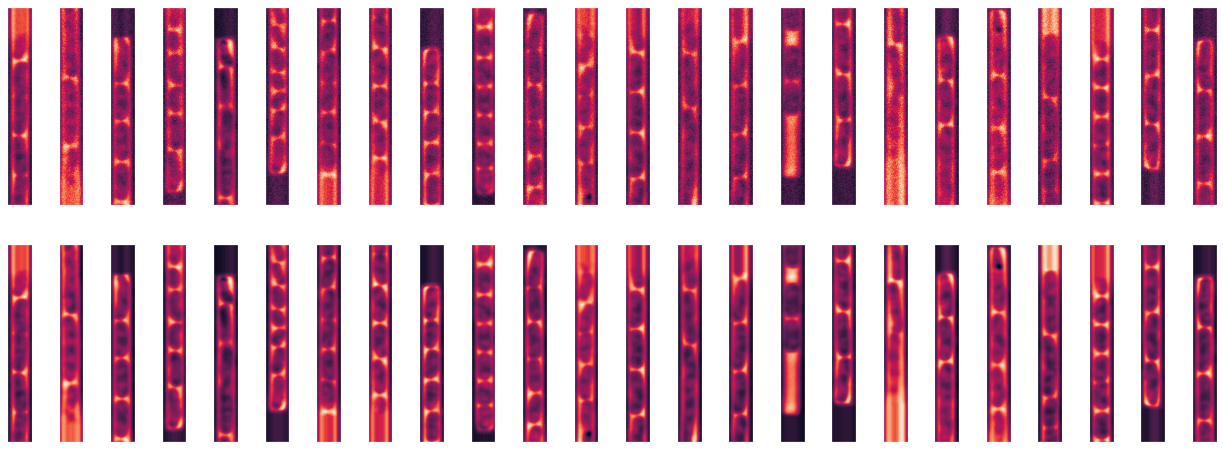

In [ ]:
def plot_small_batches(n_batches=6, n=4, labx=None, laby=None):
    fig, axes = plt.subplots(2, n_batches * n, figsize=(22, 8), sharex="all", sharey="all")
    for batch in range(n_batches):
        bx, by = x_train[batch]
        for i in range(n):
            axes[0][i + batch * n].imshow(bx[i].squeeze(-1))
            axes[1][i + batch * n].imshow(by[i].squeeze(-1))
            axes[0][i + batch * n].get_xaxis().set_visible(False)
            axes[1][i + batch * n].get_yaxis().set_visible(False)
            axes[0][i + batch * n].get_xaxis().set_ticks([])
            axes[1][i + batch * n].get_yaxis().set_ticks([])

plot_small_batches()

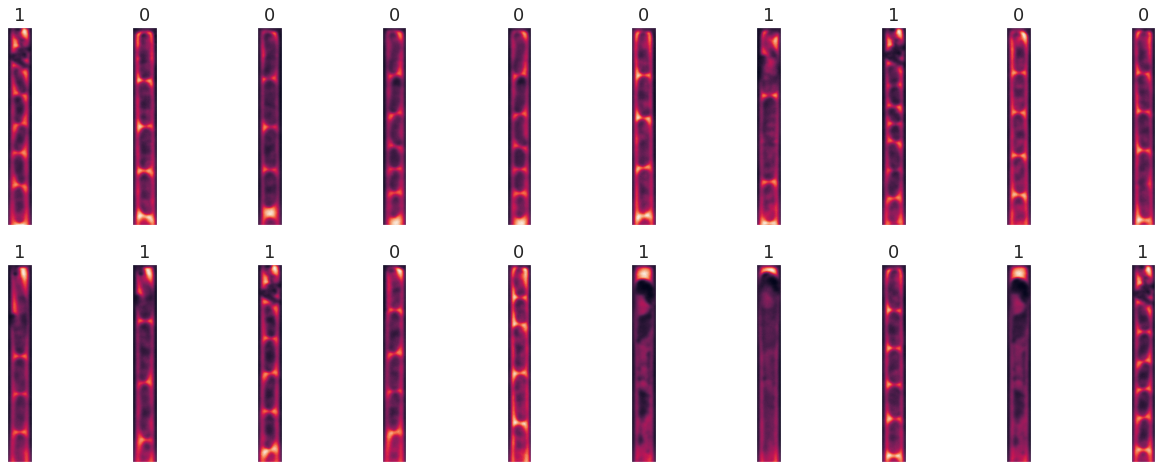

In [ ]:
# check if the labels in x_test correspond to the images

def plot_images(bx, labs, n_ims=20):
    fig, axes = plt.subplots(2, (n_ims + 1) // 2, figsize=(22, 8), sharex="all", sharey="all")

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(bx[i].squeeze(-1))
        ax.set_title(int(labs[i]))
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

bx, (by, labsy) = x_test[0]
plot_images(by, labsy, n_ims=20)

## Define model

In [ ]:
from uad.models.architecture import get_unet_vae

n_filters = 60
n_contractions = 3
input_dims = (32, 32, 3)
latent_depth = n_filters * int(2**n_contractions)
latent_dims = (int(32 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
batchnorm, dropout = False, 0
spatial_dropout = 0.2
k_size = (3, 3)

encoder, decoder = get_unet_vae(n_filters=n_filters, n_contractions=n_contractions, 
                      input_dims=input_dims, k_size=k_size, batchnorm=batchnorm, 
                      dropout=dropout, spatial_dropout=spatial_dropout, activation_function="leaky_relu")

print(encoder.summary(), decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 60)   1680        encoder_inputs[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 60)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 60)   32460       leaky_re_lu[0][0]                
____________________________________________________________________________________________